# Excitation Signals for Room Impulse Response Measurement

### Criteria
- Sufficient signal energy over the entire frequency range of interest
- Dynamic range
- Creast factor (peak-to-RMS value)
- Noise rejection (repetition and average, longer duration)
- Measurement duration
- Time variance
- Nonlinear distortion

#### _References_
* Müller, Swen, and Paulo Massarani. "Transfer-function measurement with sweeps." Journal of the Audio Engineering Society 49.6 (2001): 443-471.
[link](http://www.aes.org/e-lib/browse.cfm?elib=10189)

* Farina, Angelo. "Simultaneous measurement of impulse response and distortion with a swept-sine technique." Audio Engineering Society Convention 108. Audio Engineering Society, 2000.
[link](http://www.aes.org/e-lib/browse.cfm?elib=10211)

* Farina, Angelo. "Advancements in impulse response measurements by sine sweeps." Audio Engineering Society Convention 122. Audio Engineering Society, 2007.
[link](http://www.aes.org/e-lib/browse.cfm?elib=14106)


In [1]:
import tools
import numpy as np
from scipy.signal import chirp, max_len_seq, freqz, fftconvolve, resample
import matplotlib.pyplot as plt
import sounddevice as sd
%matplotlib inline

In [2]:
def crest_factor(x):
    """Peak-to-RMS value (crest factor) of the signal x

    Parameter
    ---------
    x : array_like
        signal
    """

    return np.max(np.abs(x)) / np.sqrt(np.mean(x**2))


def circular_convolve(x, y, outlen):
    """Circular convolution of x and y

    Parameters
    ----------
    x : array_like
        Real-valued signal
    y : array_like
        Real-valued signal
    outlen : int
        Length of the output
    """

    return np.fft.irfft(np.fft.rfft(x, n=outlen) * np.fft.rfft(y, n=outlen), n=outlen)


def plot_time_domain(x, fs=44100, ms=False):

    time = np.arange(len(x)) / fs
    timeunit = 's'
    if ms:
        time *= 1000
        timeunit = 'ms'
    
    fig = plt.figure()
    plt.plot(time, x)
    plt.xlabel('Time / {}'.format(timeunit))
    return


def plot_freq_domain(x, fs=44100, khz=False):

    Nf = len(x) // 2 + 1
    freq = np.arange(Nf) / Nf * fs / 2
    frequnit = 'Hz'
    if khz:
        freq /= 1000
        frequnit = 'kHz'

    fig = plt.figure()
    plt.plot(freq, tools.db(np.fft.rfft(x)))
    plt.xscale('log')
    plt.xlabel('Frequency / {}'.format(frequnit))
    plt.ylabel('Magnitude / dB')
    return


def compare_irs(h1, h2, ms=False):
    t1 = np.arange(len(h1)) / fs
    t2 = np.arange(len(h2)) / fs
    timeunit = 's'
    if ms:
        t1 *= 1000
        t2 *= 1000
        timeunit = 'ms'
    fig = plt.figure()
    plt.plot(t1, h1, t2, h2)
    plt.xlabel('Time / {}'.format(timeunit))
    return


def compare_tfs(h1, h2, khz=False):
    n1 = len(h1) // 2 + 1
    n2 = len(h2) // 2 + 1
    f1 = np.arange(n1) / n1 * fs / 2 
    f2 = np.arange(n2) / n2 * fs / 2
    frequnit = 'Hz'
    if khz:
        freq /= 1000
        frequnit = 'khz'
    fig = plt.figure()
    plt.plot(f1, tools.db(np.fft.rfft(h1)), f2, tools.db(np.fft.rfft(h2)))
    plt.xscale('log')
    plt.xlabel('Frequency / {}'.format(frequnit))
    plt.ylabel('Magnitude / dB')
    return


def pad_zeros(x, nzeros):
    """Append zeros at the end of the input sequence
    """
    return np.pad(x, (0, nzeros), mode='constant', constant_values=0)

## Parameters

In [3]:
fs = 44100
dur = 1
L = int(np.ceil(dur * fs))
time = np.arange(L) / fs

## White Noise

Generate a random signal with normal (Gaussian) amplitude distribution. Use `numpy.random.randn` and normalize the amplitude with `tools.normalize`.

Let's listen to it.

In [4]:
noise = np.random.randn(dur*fs)
noise = tools.normalize(noise)

In [6]:
sd.play(noise)

Plot the signal in the time domain and in the frequency domain.

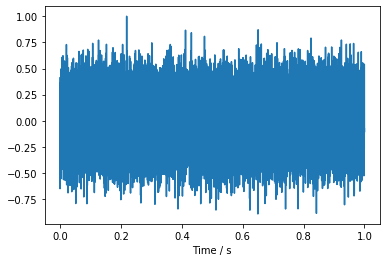

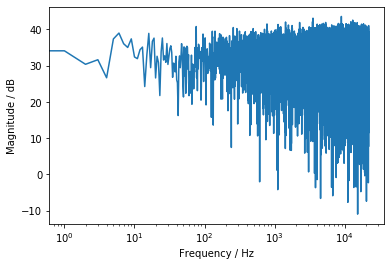

In [56]:
plot_time_domain(noise)
plot_freq_domain(noise)

Is the signal really white?

--> True white noise is obtained in the limit as the sampling rate goes to infinity and as time goes to plus and minus infinity. In other words, we never work with true white noise, but rather a finite time-segment from a white noise which has been band-limited to less than half the sampling rate and sampled.

What is the crest factor of a white noise?

In [9]:
crest_factor(noise)

4.13480814252759

Now feed the white noise to an unkown system `tools.blackbox` and save the output signal.

In [10]:
y_noise = tools.blackbox(noise, fs)

How do you think we can extract the impulse response of the system?
Try to compute the impulse response from the output signal.
Compare it with the actual impulse response which can be obtained by feeding an ideal impulse to `tools.blackbox`.

In [ ]:
dirac = np.zeros(fs*dur)
dirac[0] = 1

h_dirac = tools.blackbox(dirac, fs)
h_noise = np.fft.irfft( np.fft.rfft(y_noise)/np.fft.rfft(noise))

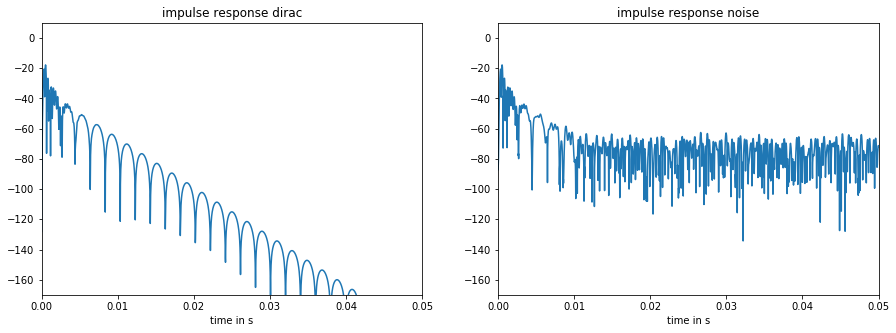

In [24]:
time = np.arange(len(noise))/fs

plt.figure(figsize = (15,5))
plt.subplot(121)
plt.plot(time, tools.db(h_dirac))
plt.ylim(-170,10)
plt.xlim(0,0.05)
plt.title('impulse response dirac');
plt.xlabel('time in s');

plt.subplot(122)
plt.plot(time, tools.db(h_noise))
plt.ylim(-170,10)
plt.xlim(0,0.05)
plt.title('impulse response noise');
plt.xlabel('time in s');

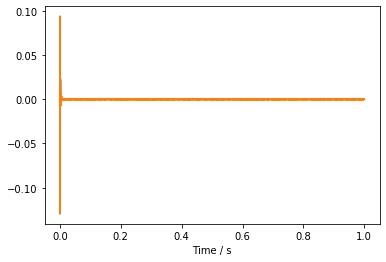

In [25]:
compare_irs(h_dirac, h_noise)

## Maximum Length Sequence

> Maximum-length sequences (MLSs) are binary sequences that can be generated very easily with an N-staged shift register and an XOR gate (with up to four inputs) connected with the shift register in such a way that all possible 2N states, minus the case "all 0," are run through. This can be accomplished by hardware with very few simple TTL ICs or by software with less than 20 lines of assembly code.

(Müller 2001)

In [26]:
nbit = int(np.ceil(np.log2(L)))
mls, _ = max_len_seq(nbit)  # sequence of 0 and 1
mls = 2*mls - 1  # sequence of -1 and 1

Take a look at the signal in the time domain.

(0, 0.01)

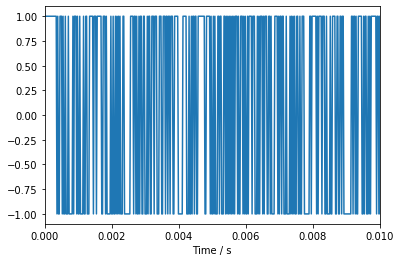

In [30]:
plot_time_domain(mls)
plt.xlim(0,0.01)

Examine the properties of the MLS
* frequency response
* crest factor
* simulate the impulse response measurement of `tools.blackbox`
* evaluate the obtained impulse response

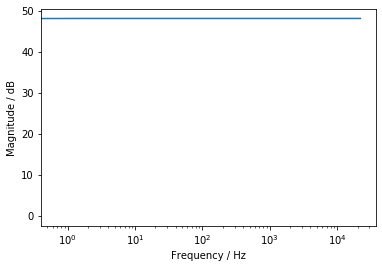

In [31]:
plot_freq_domain(mls)

In [32]:
crest_factor(mls)

1.0

(-170, 10)

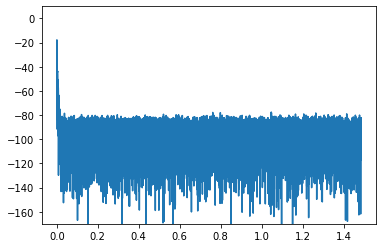

In [37]:
#impulse response

y_mls = tools.blackbox(mls, fs)
h_mls = np.fft.irfft( np.fft.rfft(y_mls) / np.fft.rfft(mls))

time = np.arange(len(mls)-1)/fs

plt.plot(time, tools.db(h_mls))
plt.ylim(-170,10)
#plt.xlim(0,2000)


In practive, the (digital) signal has to be converted into an analog signal by an audio interface?
Here, the process is simulated by oversampling the signal by a factor of 10.
Pay attention to the crest factor before and after upsampling.

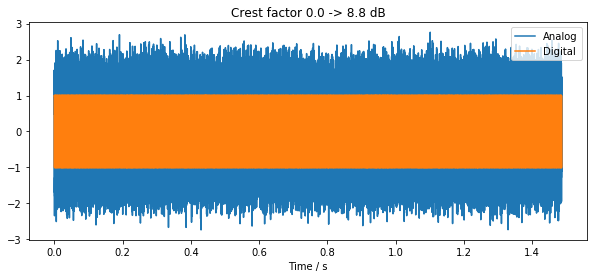

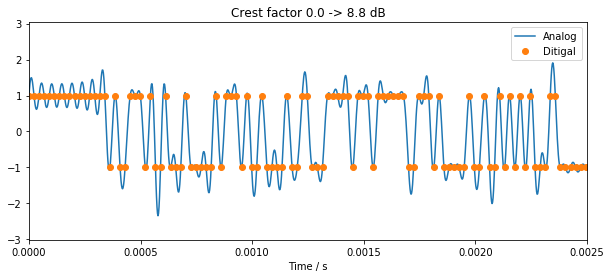

In [61]:
upsample = 10
mls_up = resample(mls, num=len(mls) * upsample)
time = np.arange(len(mls)) / fs
time_up = np.arange(len(mls_up)) / fs / upsample

plt.figure(figsize=(10, 4))
plt.plot(time_up, mls_up, '-', label='Analog')
plt.plot(time, mls, '-', label='Digital')
plt.legend(loc='best')
plt.xlabel('Time / s')
plt.title('Crest factor {:.1f} -> {:.1f} dB'.format(tools.db(crest_factor(mls)), tools.db(crest_factor(mls_up))))

plt.figure(figsize=(10, 4))
plt.plot(time_up, mls_up, '-', label='Analog')
plt.plot(time, mls, 'o', label='Ditigal')
plt.xlim(0, 0.0025)
plt.legend(loc='best')
plt.xlabel('Time / s')
plt.title('Crest factor {:.1f} -> {:.1f} dB'.format(tools.db(crest_factor(mls)), tools.db(crest_factor(mls_up))));

## Linear Sweep

Generate a linear sweep with `lin_sweep`.

In [38]:
def lin_sweep(fstart, fstop, duration, fs):
    """Generation of a linear sweep signal.

    Parameters
    ----------
    fstart : int
           Start frequency in Hz
    fstop  : int
           Stop frequency in Hz
    duration : float
           Total length of signal in s
    fs : int
           Sampling frequency in Hz

    Returns
    -------
    array_like
         generated signal vector

    Note that the stop frequency must not be greater than half the
    sampling frequency (Nyquist-Shannon sampling theorem).

    """
    if fstop > fs / 2:
        raise ValueError("fstop must not be greater than fs/2")
    t = np.arange(0, duration, 1 / fs)
    excitation = np.sin(
        2 * np.pi * ((fstop - fstart) /
                     (2 * duration) * t ** 2 + fstart * t))
    # excitation = excitation - np.mean(excitation)  # remove direct component
    return excitation

In [39]:
fs = 44100
fstart = 20
fstop = 20000
duration = 1

lsweep = lin_sweep(fstart, fstop, duration, fs)

Examine the properties of linear sweeps
* spectrogram (Use `pyplot.specgram` with `NFFT=512` and `Fs=44100`)
* frequency response
* crest factor
* simulate the impulse response measurement of `tools.blackbox`
* evaluate the obtained impulse response

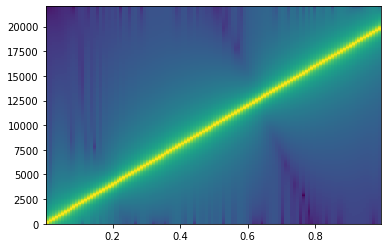

In [40]:
plt.specgram(lsweep, NFFT=512, Fs=44100);

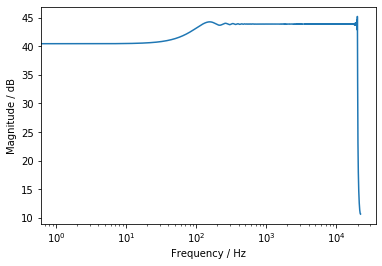

In [41]:
plot_freq_domain(lsweep)

In [42]:
crest_factor(lsweep)

1.4149068951456858

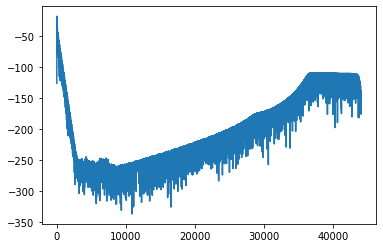

In [43]:
y_lsweep = tools.blackbox(lsweep, fs)
h_sweep = np.fft.irfft( np.fft.rfft(y_lsweep)/np.fft.rfft(lsweep))

plt.plot(tools.db(h_sweep))

## Exponential Sweep

Generate a exponential sweep with `exp_sweep`.

In [44]:
def exp_sweep(fstart, fstop, duration, fs):
    """Generation of a exponential sweep signal.

    Parameters
    ----------
    fstart : int
           Start frequency in Hz
    fstop  : int
           Stop frequency
    duration : float
           Total length of signal in s
    fs : int
           Sampling frequency in Hz

    Returns
    -------
    array_like
           Generated signal vector

    Note that the stop frequency must not be greater than half the
    sampling frequency (Nyquist-Shannon sampling theorem).

    """
    if fstop > fs / 2:
        raise ValueError("fstop must not be greater than fs/2")
    t = np.arange(0, duration, 1 / fs)
    excitation = np.sin(2 * np.pi * duration *
                        fstart / np.log(fstop / fstart) *
                        (np.exp(t / duration * np.log(fstop / fstart)) - 1))
    # excitation = excitation - np.mean(excitation)  # remove direct component
    return excitation

In [45]:
fs = 44100
fstart = 20
fstop = 20000
duration = 1

esweep = exp_sweep(fstart, fstop, duration, fs)

Examine the properties of linear sweeps
* spectrogram (Use `pyplot.specgram` with `NFFT=512` and `Fs=44100`)
* frequency response
* crest factor
* simulate the impulse response measurement of `tools.blackbox`
* evaluate the obtained impulse response

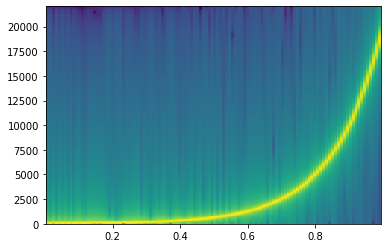

In [46]:
plt.specgram(esweep, NFFT=512, Fs=44100);

In [48]:
crest_factor(esweep)

1.4143212242386742

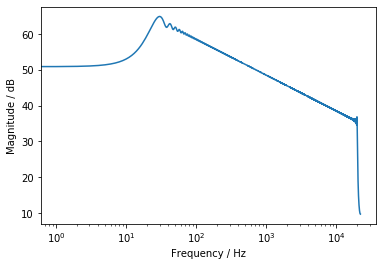

In [49]:
plot_freq_domain(esweep)

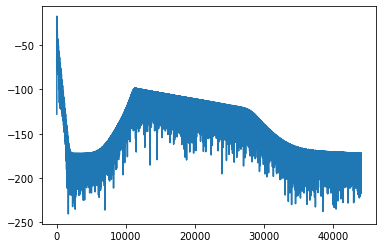

In [51]:
y_esweep = tools.blackbox(esweep, fs)
h_esweep = np.fft.irfft( np.fft.rfft(y_esweep)/np.fft.rfft(esweep))

plt.plot(tools.db(h_esweep))